In [1]:
import time
import os

import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from keras import layers
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [2]:
max_words = 100000
max_len = 500
embedding_dim = 50
lstm_out = 200

In [3]:
df_source = pd.read_json('singlelabel2.json',lines=True)
df_source.head()

,_id,categories,text
0,{'$oid': '5cdbc77bc201f803ecf30d42'},Tweet,#FollowFriday @France_Inte @PKuchly57 @Milipol...
1,{'$oid': '5cdbc77bc201f803ecf30d43'},Tweet,@Lamb2ja Hey James! How odd :/ Please call our...
2,{'$oid': '5cdbc77bc201f803ecf30d44'},Tweet,@DespiteOfficial we had a listen last night :)...
3,{'$oid': '5cdbc77bc201f803ecf30d45'},Tweet,@97sides CONGRATS :)
4,{'$oid': '5cdbc77bc201f803ecf30d46'},Tweet,yeaaaah yippppy!!! my accnt verified rqst has...


In [4]:
text = df_source['text'].values
y = df_source['categories'].values

text,y

(array(['#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)',
        '@Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!',
        '@DespiteOfficial we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!',
        ...,
        'I can hear my neighbours shagging and the only thing that distinguishes it from the noise they make when theyâ€™re watching Spurs is that I can also hear Guns N Roses playing ',
        "My colleague doesn't drink tea. Or coffee. Or any other hot drink. ",
        'Can we talk for a second about the fuckers who accelerate when you indicate youâ€™re about to change lanes? Iâ€™ve been doing a lot of motorway driving recently and I swear these fuckers are everywhere. Youâ€™re going down the motorway and ahead thereâ€™s one lorry overtaking another at 61mph (vs 60mph in the left lane) so you ind

In [5]:
sentences_train, sentences_test, categories_train, categories_test = train_test_split(text, y, test_size=0.25, random_state=1000)

In [6]:
tokenizer = Tokenizer(num_words=100000)
vectorizer_categories = CountVectorizer()
tokenizer.fit_on_texts(sentences_train)
vectorizer_categories.fit(categories_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)
y_train = vectorizer_categories.transform(categories_train)
y_test = vectorizer_categories.transform(categories_test)

vocab_size = len(tokenizer.word_index) + 1

X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
X_test = pad_sequences(X_test, padding='post', maxlen=max_len)

In [7]:
X_train.shape

(25925, 500)

In [8]:
keras.backend.clear_session()

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size,
                          output_dim=embedding_dim,
                          input_length=max_len))
#model.add(layers.Flatten())
#model.add(layers.GlobalMaxPool1D())
model.add(layers.LSTM(lstm_out, return_sequences=True, activation='tanh', recurrent_activation='hard_sigmoid'))
model.add(layers.LSTM(lstm_out))
model.add(layers.Dense(28, activation='softmax'))
#model.add(layers.Dense(250, activation='softmax'))
model.add(layers.Dense(5, activation='relu'))
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 50)           8391200   
_________________________________________________________________
lstm_1 (LSTM)                (None, 500, 200)          200800    
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_1 (Dense)              (None, 28)                5628      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 145       
Total params: 8,918,573
Trainable params: 8,918,573
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.inputs

[<tf.Tensor 'embedding_1_input:0' shape=(?, 500) dtype=float32>]

In [10]:
history = model.fit(X_train, y_train,
                   epochs=1,
                   validation_data=(X_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 25925 samples, validate on 8642 samples
Epoch 1/1
25925/25925 [==============================] - 1302s 50ms/step - loss: 2.1899 - acc: 0.8026 - val_loss: 2.3589 - val_acc: 0.8064


In [21]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [22]:
loss, accuracy = model.evaluate(X_train, y_train)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test)
print("Testing Accuracy:  {:.4f}".format(accuracy))

25925/25925 [==============================] - 365s 14ms/step
Training Accuracy: 0.8062
8642/8642 [==============================] - 123s 14ms/step
Testing Accuracy:  0.8064


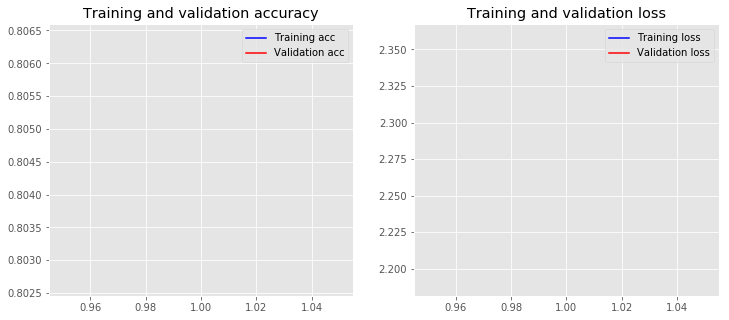

In [27]:
plot_history(model.history)

In [28]:
df_test = pd.read_csv('test_twitter_data.csv')

test = df_test['features'].values
test_twitter = tokenizer.texts_to_sequences(test)
test_twitter = pad_sequences(test_twitter, padding='post', maxlen=max_len)

test_one_twitter = tokenizer.texts_to_sequences([test[1]])
test_one_twitter = pad_sequences(test_one_twitter, padding='post', maxlen=max_len)

test_one_news = tokenizer.texts_to_sequences(["The legal action, filed in New York's Southern District, is against Deutsche Bank, one of Trump's lenders, and Capital One. Both banks \"have long provided business and personal banking services to Plaintiffs,\" Trump's attorneys said.\"The subpoenas were issued to harass President Donald J. Trump, to rummage through every aspect of his personal finances, his businesses, and the private information of the President and his family, and to ferret about for any material that might be used to cause him political damage. No grounds exist to establish any purpose other than a political one,\" Trump's attorneys wrote in the complaint filed late Monday."])
test_one_news = pad_sequences(test_one_news, padding='post', maxlen=max_len)

test_one_reddit = tokenizer.texts_to_sequences(["I paid a friend of mine some money to draw me a skin for Mercy I've always wanted. Yes, I know she's Swiss. No, I don't care. I wish it was a skin in game so I could ALWAYS USE IT. And against my better judgement I've posted it here to show off how good my friends art is. I hope y'all enjoy it, and if you don't, that's okay too ♥ Edit: She replied! https://www.instagram.com/jenv_arts/ and https://twitter.com/jenv_arts Enjoy everyone!"])
test_one_reddit = pad_sequences(test_one_reddit, padding='post', maxlen=max_len)

test_one_random = tokenizer.texts_to_sequences(["They dont need a product I've said it countless times there are groups that are just writing a report about analysing a data set using the exact same process we did in class Our product would be the code that cleaned and processed the data, the code that collected it, and hopefully if achievable the tensorflow program that trains a model to do something"])
test_one_random = pad_sequences(test_one_random, padding='post', maxlen=max_len)

In [29]:
vectorizer_categories.vocabulary_

{'spook': 2, 'story': 3, 'joke': 0, 'news': 1, 'tweet': 4}

In [30]:
prediction = model.predict(test_twitter)
i = 0
j = 0
for x in np.round(prediction, decimals=3):
    i = i + 1
    print(i)
    if x[2] < 0.80:
        j = j + 1
        print("[DING DONG]x" + str(j))
    print("News: " + str(np.format_float_positional(x[0], pad_right=3)) + " | Reddit: " + str(np.format_float_positional(x[1], pad_right=3)) + " | Twitter: " + str(np.format_float_positional(x[2], pad_right=3)) + "\n")

1
[DING DONG]x1
News: -0.    | Reddit: -0.    | Twitter: -0.   

2
[DING DONG]x2
News: -0.    | Reddit: -0.    | Twitter: -0.   

3
[DING DONG]x3
News: -0.    | Reddit: -0.    | Twitter: -0.   

4
[DING DONG]x4
News: -0.    | Reddit: -0.    | Twitter: -0.   

5
[DING DONG]x5
News: -0.    | Reddit: -0.    | Twitter: -0.   

6
[DING DONG]x6
News: -0.    | Reddit: -0.    | Twitter: -0.   

7
[DING DONG]x7
News: -0.    | Reddit: -0.    | Twitter: -0.   

8
[DING DONG]x8
News: -0.    | Reddit: -0.    | Twitter: -0.   

9
[DING DONG]x9
News: -0.    | Reddit: -0.    | Twitter: -0.   

10
[DING DONG]x10
News: -0.    | Reddit: -0.    | Twitter: -0.   

11
[DING DONG]x11
News: -0.    | Reddit: -0.    | Twitter: -0.   

12
[DING DONG]x12
News: -0.    | Reddit: -0.    | Twitter: -0.   

13
[DING DONG]x13
News: 0.13  | Reddit: 0.1   | Twitter: -0.   

14
[DING DONG]x14
News: -0.    | Reddit: -0.    | Twitter: -0.   

15
[DING DONG]x15
News: -0.    | Reddit: -0.    | Twitter: -0.   

16
[DING DONG]x

News: 0.13  | Reddit: 0.1   | Twitter: -0.   

377
[DING DONG]x377
News: -0.    | Reddit: -0.    | Twitter: -0.   

378
[DING DONG]x378
News: -0.    | Reddit: -0.    | Twitter: -0.   

379
[DING DONG]x379
News: 0.13  | Reddit: 0.1   | Twitter: -0.   

380
[DING DONG]x380
News: -0.    | Reddit: -0.    | Twitter: -0.   

381
[DING DONG]x381
News: -0.    | Reddit: -0.    | Twitter: -0.   

382
[DING DONG]x382
News: -0.    | Reddit: -0.    | Twitter: -0.   

383
[DING DONG]x383
News: -0.    | Reddit: -0.    | Twitter: -0.   

384
[DING DONG]x384
News: -0.    | Reddit: -0.    | Twitter: -0.   

385
[DING DONG]x385
News: -0.    | Reddit: -0.    | Twitter: -0.   

386
[DING DONG]x386
News: -0.    | Reddit: -0.    | Twitter: -0.   

387
[DING DONG]x387
News: -0.    | Reddit: -0.    | Twitter: -0.   

388
[DING DONG]x388
News: -0.    | Reddit: -0.    | Twitter: -0.   

389
[DING DONG]x389
News: -0.    | Reddit: -0.    | Twitter: -0.   

390
[DING DONG]x390
News: -0.    | Reddit: -0.    | Twitte


710
[DING DONG]x710
News: -0.    | Reddit: -0.    | Twitter: -0.   

711
[DING DONG]x711
News: -0.    | Reddit: -0.    | Twitter: -0.   

712
[DING DONG]x712
News: -0.    | Reddit: -0.    | Twitter: -0.   

713
[DING DONG]x713
News: -0.    | Reddit: -0.    | Twitter: -0.   

714
[DING DONG]x714
News: -0.    | Reddit: -0.    | Twitter: -0.   

715
[DING DONG]x715
News: -0.    | Reddit: -0.    | Twitter: -0.   

716
[DING DONG]x716
News: -0.    | Reddit: -0.    | Twitter: -0.   

717
[DING DONG]x717
News: -0.    | Reddit: -0.    | Twitter: -0.   

718
[DING DONG]x718
News: 0.13  | Reddit: 0.1   | Twitter: -0.   

719
[DING DONG]x719
News: -0.    | Reddit: -0.    | Twitter: -0.   

720
[DING DONG]x720
News: -0.    | Reddit: -0.    | Twitter: -0.   

721
[DING DONG]x721
News: -0.    | Reddit: -0.    | Twitter: -0.   

722
[DING DONG]x722
News: -0.    | Reddit: -0.    | Twitter: -0.   

723
[DING DONG]x723
News: -0.    | Reddit: -0.    | Twitter: -0.   

724
[DING DONG]x724
News: -0.    | 

1043
[DING DONG]x1043
News: -0.    | Reddit: -0.    | Twitter: -0.   

1044
[DING DONG]x1044
News: -0.    | Reddit: -0.    | Twitter: -0.   

1045
[DING DONG]x1045
News: -0.    | Reddit: -0.    | Twitter: -0.   

1046
[DING DONG]x1046
News: -0.    | Reddit: -0.    | Twitter: -0.   

1047
[DING DONG]x1047
News: -0.    | Reddit: -0.    | Twitter: -0.   

1048
[DING DONG]x1048
News: -0.    | Reddit: -0.    | Twitter: -0.   

1049
[DING DONG]x1049
News: -0.    | Reddit: -0.    | Twitter: -0.   

1050
[DING DONG]x1050
News: -0.    | Reddit: -0.    | Twitter: -0.   

1051
[DING DONG]x1051
News: -0.    | Reddit: -0.    | Twitter: -0.   

1052
[DING DONG]x1052
News: -0.    | Reddit: -0.    | Twitter: -0.   

1053
[DING DONG]x1053
News: -0.    | Reddit: -0.    | Twitter: -0.   

1054
[DING DONG]x1054
News: -0.    | Reddit: -0.    | Twitter: -0.   

1055
[DING DONG]x1055
News: -0.    | Reddit: -0.    | Twitter: -0.   

1056
[DING DONG]x1056
News: -0.    | Reddit: -0.    | Twitter: -0.   

1057
[

1376
[DING DONG]x1376
News: -0.    | Reddit: -0.    | Twitter: -0.   

1377
[DING DONG]x1377
News: -0.    | Reddit: -0.    | Twitter: -0.   

1378
[DING DONG]x1378
News: -0.    | Reddit: -0.    | Twitter: -0.   

1379
[DING DONG]x1379
News: -0.    | Reddit: -0.    | Twitter: -0.   

1380
[DING DONG]x1380
News: -0.    | Reddit: -0.    | Twitter: -0.   

1381
[DING DONG]x1381
News: -0.    | Reddit: -0.    | Twitter: -0.   

1382
[DING DONG]x1382
News: -0.    | Reddit: -0.    | Twitter: -0.   

1383
[DING DONG]x1383
News: -0.    | Reddit: -0.    | Twitter: -0.   

1384
[DING DONG]x1384
News: -0.    | Reddit: -0.    | Twitter: -0.   

1385
[DING DONG]x1385
News: -0.    | Reddit: -0.    | Twitter: -0.   

1386
[DING DONG]x1386
News: -0.    | Reddit: -0.    | Twitter: -0.   

1387
[DING DONG]x1387
News: -0.    | Reddit: -0.    | Twitter: -0.   

1388
[DING DONG]x1388
News: -0.    | Reddit: -0.    | Twitter: -0.   

1389
[DING DONG]x1389
News: -0.    | Reddit: -0.    | Twitter: -0.   

1390
[

[DING DONG]x1709
News: -0.    | Reddit: -0.    | Twitter: -0.   

1710
[DING DONG]x1710
News: -0.    | Reddit: -0.    | Twitter: -0.   

1711
[DING DONG]x1711
News: -0.    | Reddit: -0.    | Twitter: -0.   

1712
[DING DONG]x1712
News: -0.    | Reddit: -0.    | Twitter: -0.   

1713
[DING DONG]x1713
News: -0.    | Reddit: -0.    | Twitter: -0.   

1714
[DING DONG]x1714
News: -0.    | Reddit: -0.    | Twitter: -0.   

1715
[DING DONG]x1715
News: -0.    | Reddit: -0.    | Twitter: -0.   

1716
[DING DONG]x1716
News: -0.    | Reddit: -0.    | Twitter: -0.   

1717
[DING DONG]x1717
News: -0.    | Reddit: -0.    | Twitter: -0.   

1718
[DING DONG]x1718
News: -0.    | Reddit: -0.    | Twitter: -0.   

1719
[DING DONG]x1719
News: -0.    | Reddit: -0.    | Twitter: -0.   

1720
[DING DONG]x1720
News: -0.    | Reddit: -0.    | Twitter: -0.   

1721
[DING DONG]x1721
News: -0.    | Reddit: -0.    | Twitter: -0.   

1722
[DING DONG]x1722
News: -0.    | Reddit: -0.    | Twitter: -0.   

1723
[DING 

In [17]:
prediction = model.predict(test_one_twitter)
for x in np.round(prediction, decimals=3):
    print("News: " + str(np.format_float_positional(x[0], pad_right=3)) + " | Reddit: " + str(np.format_float_positional(x[1], pad_right=3)) + " | Twitter: " + str(np.format_float_positional(x[2], pad_right=3)) + "\n")

News: -0.    | Reddit: -0.    | Twitter: -0.   



In [18]:
prediction = model.predict(test_one_news)
for x in np.round(prediction, decimals=3):
    print("News: " + str(np.format_float_positional(x[0], pad_right=3)) + " | Reddit: " + str(np.format_float_positional(x[1], pad_right=3)) + " | Twitter: " + str(np.format_float_positional(x[2], pad_right=3)) + "\n")

News: -0.    | Reddit: -0.    | Twitter: -0.   



In [19]:
prediction = model.predict(test_one_reddit)
for x in np.round(prediction, decimals=3):
    print("News: " + str(np.format_float_positional(x[0], pad_right=3)) + " | Reddit: " + str(np.format_float_positional(x[1], pad_right=3)) + " | Twitter: " + str(np.format_float_positional(x[2], pad_right=3)) + "\n")

News: -0.    | Reddit: -0.    | Twitter: -0.   



In [20]:
prediction = model.predict(test_one_random)
for x in np.round(prediction, decimals=3):
    print("News: " + str(np.format_float_positional(x[0], pad_right=3)) + " | Reddit: " + str(np.format_float_positional(x[1], pad_right=3)) + " | Twitter: " + str(np.format_float_positional(x[2], pad_right=3)) + "\n")

News: -0.    | Reddit: -0.    | Twitter: -0.   



In [36]:
dir(model.history)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'epoch',
 'history',
 'model',
 'on_batch_begin',
 'on_batch_end',
 'on_epoch_begin',
 'on_epoch_end',
 'on_train_begin',
 'on_train_end',
 'params',
 'set_model',
 'set_params',
 'validation_data']